## Fit IGM nuisance parameters to existing P1D, one z at a time

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time, os, sys
import matplotlib.pyplot as plt

# our own modules
from lace.emulator.emulator_manager import set_emulator
from cup1d.p1ds import (
    data_Chabanier2019,
    data_Ravoux2023,
    data_Karacayli2024,
    data_Karacayli2022
)
from cup1d.likelihood import lya_theory, likelihood, emcee_sampler
from cup1d.likelihood.sampler_pipeline import set_archive, set_P1D, set_P1D_hires, set_fid_cosmo, set_like
from cup1d.likelihood.input_pipeline import Args

In [2]:
# args = Args(emulator_label="Pedersen21")
args = Args(emulator_label="Pedersen23_ext8", training_set="Cabayol23")
# args = Args(emulator_label="Cabayol23+", training_set="Cabayol23")
# args = Args(emulator_label="Nyx_alphap", training_set="Nyx23_Oct2023")

In [3]:
args.data_label = "Chabanier19"
#args.data_label = "Ravoux23"
#args.data_label = "Karacayli24"
args.data_label_hires = "Karacayli22"
args.add_hires = True
args.add_metals = True
# development
args.n_igm=1
args.n_steps=40
args.n_burn_in=10
args.parallel=False
args.explore=False

In [4]:
z_min=2.2
z_max=3.8
zs=np.arange(z_min,z_max+0.01,0.2)
Nz=len(zs)
print(Nz, zs)
# how many zs to plot
plot_every_iz=2
# trim wavenumbers in low-resolution and high-resolution P1Ds
lr_kmin_kms=0.002
lr_kmax_kms=0.012
hr_kmin_kms=0.009

9 [2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8]


### Set archive

In [5]:
archive = set_archive(args.training_set)

### Set emulator

In [6]:
emulator = set_emulator(
    emulator_label=args.emulator_label,
    archive=archive,
)

Use custom archive provided by the user
Select emulator in Pedersen23_ext8
Gaussian Process emulator predicting the P1D, fitting coefficients to a 5th degree polynomial. It goes to scales of 8 Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones


 /Users/afont/Codes/igmhub/LaCE/lace/emulator/gp_emulator.py:266: UserWarning:Enforce average=both in training of GP emulator
 /Users/afont/Codes/igmhub/LaCE/lace/emulator/gp_emulator.py:268: UserWarning:Enforce val_scalinge=1 in training of GP emulator
 /opt/miniconda3/envs/cup1d/lib/python3.11/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.23 seconds


### Set fiducial cosmology

In [7]:
cosmo_fid = set_fid_cosmo(cosmo_label=args.cosmo_label)

### Set likelihoods (one per redshift bin)

In [8]:
def get_onez_likelihood(z):
    data, true_sim_igm = set_P1D(
        archive,
        emulator,
        args.data_label,
        cosmo_fid,
        cov_label=args.cov_label,
        apply_smoothing=False,
        z_min=z-0.01,
        z_max=z+0.01,
    )

    data.cull_data(kmin_kms=lr_kmin_kms,kmax_kms=lr_kmax_kms)

    extra_data = set_P1D_hires(
        archive,
        emulator,
        cosmo_fid,
        args.data_label_hires,
        args.cov_label_hires,
        apply_smoothing=False,
        z_min=z-0.01,
        z_max=z+0.01,
    )

    extra_data.cull_data(kmin_kms=hr_kmin_kms)
    
    like = set_like(
        emulator,
        data,
        extra_data,
        true_sim_igm,
        args.igm_label,
        1,
        cosmo_fid,
        fix_cosmo=True,
        add_metals=args.add_metals,
    )
    
    return like

In [9]:
allz_runs=[]
for iz,z in enumerate(zs):
    like = get_onez_likelihood(z)
    onez_run={'z':z, 'like':like}
    allz_runs.append(onez_run)

Nz = 14 , Nk = 13
Using 1 parameters for IGM model
free parameters ['ln_tau_0', 'ln_sigT_kms_0', 'ln_gamma_0', 'ln_kF_0', 'ln_SiIII_0']
metal tag ln_SiIII
will not store truth, working with real data
will not store truth, working with real data
Nz = 14 , Nk = 13
Using 1 parameters for IGM model
free parameters ['ln_tau_0', 'ln_sigT_kms_0', 'ln_gamma_0', 'ln_kF_0', 'ln_SiIII_0']
metal tag ln_SiIII
will not store truth, working with real data
will not store truth, working with real data
Nz = 14 , Nk = 13
Using 1 parameters for IGM model
free parameters ['ln_tau_0', 'ln_sigT_kms_0', 'ln_gamma_0', 'ln_kF_0', 'ln_SiIII_0']
metal tag ln_SiIII
will not store truth, working with real data
will not store truth, working with real data
Nz = 14 , Nk = 13
Using 1 parameters for IGM model
free parameters ['ln_tau_0', 'ln_sigT_kms_0', 'ln_gamma_0', 'ln_kF_0', 'ln_SiIII_0']
metal tag ln_SiIII
will not store truth, working with real data
will not store truth, working with real data
Nz = 14 , Nk = 13
Us

In [10]:
if False:
#for iz in range(Nz):
    plt.figure()
    allz_runs[iz]['like'].plot_p1d(residuals=False)
    allz_runs[iz]['like'].extra_p1d_like.plot_p1d(residuals=False)
    plt.xscale('log')

In [11]:
def fit_onez_likelihood(like, initial_values=None, run_sampler=False):
    def log_prob(theta):
        return log_prob.sampler.like.log_prob_and_blobs(theta)

    def set_log_prob(sampler):
        log_prob.sampler = sampler
        return log_prob

    sampler = emcee_sampler.EmceeSampler(
        like=like,
        rootdir=".",
        save_chain=False,
        nburnin=args.n_burn_in,
        nsteps=args.n_steps,
        parallel=args.parallel,
        explore=args.explore,
        fix_cosmology=args.fix_cosmo,
    )
    _log_prob = set_log_prob(sampler)

    if run_sampler:
        _emcee_sam = sampler.run_sampler(log_func=_log_prob)
        ind = np.argmax(sampler.lnprob.reshape(-1))
        nparam = sampler.chain.shape[-1]
        initial_values = sampler.chain.reshape(-1, nparam)[ind, :]
        print('MLE from chain will be initial value in minimizer',initial_values)

    npar=len(like.free_params)
    if initial_values is None:
        initial_values=0.5*np.ones(npar)
    else:
        print('starting from point',initial_values)
    sampler.run_minimizer(log_func=_log_prob,p0=initial_values)
    
    return sampler

In [12]:
# turn this on to use the best-fit from the previous z-bin as a starting point
recycle_best_fit=False
run_sampler=True
for iz in range(Nz):
    if recycle_best_fit and iz>0:
        initial_values=allz_runs[iz-1]['best_fit_values']
        print(initial_values)
    else:
        initial_values=None
    sampler = fit_onez_likelihood(allz_runs[iz]['like'],
                                  initial_values=initial_values,run_sampler=run_sampler)
    allz_runs[iz]['sampler']=sampler
    # store chi2 and Ndof
    allz_runs[iz]['best_fit_values']=sampler.mle_cube
    npar=len(allz_runs[iz]['best_fit_values'])
    # low-resolution (eBOSS/DESI) chi2 / Nk
    allz_runs[iz]['lr_chi2']=sampler.like.get_chi2(values=allz_runs[iz]['best_fit_values'])
    allz_runs[iz]['lr_Nk']=len(sampler.like.data.k_kms[0])
    # high-resolution chi2 / Nk
    allz_runs[iz]['hr_chi2']=sampler.like.extra_p1d_like.get_chi2(values=allz_runs[iz]['best_fit_values'])
    allz_runs[iz]['hr_Nk']=len(sampler.like.extra_p1d_like.data.k_kms[0])

Created directory: ./chain_199
setup with  1  ranks,  201  walkers, and  40  steps
combined steps  10050 (should be close to  10000 )
set 201 walkers with 5 dimensions
MLE from chain will be initial value in minimizer [0.80197585 0.54344595 0.57404502 0.47198146 0.73360191]
starting from point [0.80197585 0.54344595 0.57404502 0.47198146 0.73360191]
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.8633300422072345
             x: [ 8.147e-01  5.332e-01  5.890e-01  4.562e-01  7.326e-01]
           nit: 189
          nfev: 309
 final_simplex: (array([[ 8.147e-01,  5.332e-01, ...,  4.562e-01,
                         7.326e-01],
                       [ 8.146e-01,  5.332e-01, ...,  4.562e-01,
                         7.326e-01],
                       ...,
                       [ 8.146e-01,  5.332e-01, ...,  4.562e-01,
                         7.326e-01],
                       [ 8.146e-01,  5.332e-01, ...,  4.562e-01,
       

In [13]:
if False:
#for iz in range(Nz):
    sampler=allz_runs[iz]['sampler']
    
    best_fit_values=sampler.mle_cube
    npar=len(best_fit_values)
    chi2=sampler.like.get_chi2(values=best_fit_values)
    dof=len(sampler.like.data.k_kms[0])-npar
    f, ax = plt.subplots()

    sampler.like.plot_p1d(residuals=False,values=best_fit_values)
    sampler.like.extra_p1d_like.plot_p1d(residuals=False,values=best_fit_values)
    plt.xscale('log')
    plt.text(0.5,0.1,'chi2={:.2f}, dof={}'.format(chi2,dof),transform=ax.transAxes)

    plt.savefig('p1d_lr_hr_z{}.png'.format(zs[iz]))

In [14]:
if False:
#for iz in range(Nz):
    sampler=allz_runs[iz]['sampler']
    plt.figure()
    allz_runs[iz]['like'].plot_p1d(residuals=True,values=sampler.mle_cube)
    allz_runs[iz]['like'].extra_p1d_like.plot_p1d(residuals=True,values=sampler.mle_cube)
    plt.xscale('log')
    plt.savefig('res_p1d_lr_hr_z{}.png'.format(zs[iz]))

### Look at the chi2 in each redshift

In [15]:
for iz in range(Nz):
    run=allz_runs[iz]
    npar=len(run['best_fit_values'])
    print('z = {:.1f}, chi2 (lowres = {:.2f}, highres = {:.2f}, total = {:.2f}) , Ndof = {}'.format(
            zs[iz], run['lr_chi2'], run['hr_chi2'], run['lr_chi2']+run['hr_chi2'], 
            run['lr_Nk']+run['hr_Nk']-npar))

z = 2.2, chi2 (lowres = 25.07, highres = 51.61, total = 76.69) , Ndof = 24
z = 2.4, chi2 (lowres = 19.87, highres = 13.25, total = 33.12) , Ndof = 24
z = 2.6, chi2 (lowres = 31.44, highres = 27.90, total = 59.33) , Ndof = 24
z = 2.8, chi2 (lowres = 43.27, highres = 13.61, total = 56.88) , Ndof = 24
z = 3.0, chi2 (lowres = 53.53, highres = 31.04, total = 84.57) , Ndof = 24
z = 3.2, chi2 (lowres = 33.47, highres = 6.55, total = 40.02) , Ndof = 24
z = 3.4, chi2 (lowres = 29.50, highres = 18.74, total = 48.24) , Ndof = 24
z = 3.6, chi2 (lowres = 7.16, highres = 2.16, total = 9.32) , Ndof = 24
z = 3.8, chi2 (lowres = 8.29, highres = 5.61, total = 13.89) , Ndof = 24


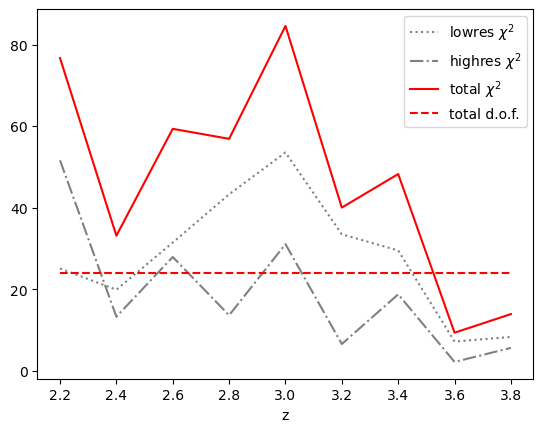

In [16]:
lr_chi2=np.array([allz_runs[iz]['lr_chi2'] for iz in range(Nz)])
hr_chi2=np.array([allz_runs[iz]['hr_chi2'] for iz in range(Nz)])
lr_Nk=np.array([allz_runs[iz]['lr_Nk'] for iz in range(Nz)])
hr_Nk=np.array([allz_runs[iz]['hr_Nk'] for iz in range(Nz)])
npar=[len(allz_runs[iz]['best_fit_values']) for iz in range(Nz)]
plt.plot(zs,lr_chi2,label=r'lowres $\chi^2$',color='gray',ls=':')
plt.plot(zs,hr_chi2,label=r'highres $\chi^2$',color='gray',ls='-.')
plt.plot(zs,lr_chi2+hr_chi2,label=r'total $\chi^2$',color='red',ls='-')
plt.plot(zs,lr_Nk+hr_Nk-npar,label=r'total d.o.f.',color='red',ls='--')
plt.legend()
plt.xlabel('z')
plt.savefig('chi2_lr_hr.png')

### Plot P1D measurements and fiducial theory models (eBOSS/DESI only)

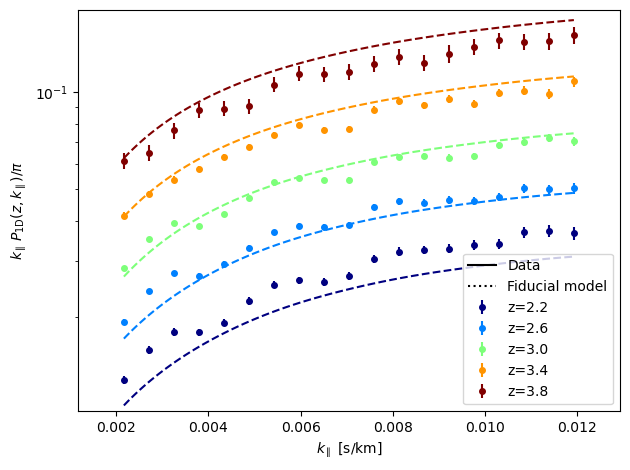

In [17]:
residuals=False
sampling_p1d=100
Nz=len(allz_runs)
# figure out y range for plot
ymin = 1e10
ymax = -1e10
for iz in range(0,Nz,plot_every_iz):
    col = plt.cm.jet(iz / (Nz - 1))
    yshift = iz / (Nz - 1)
    z=zs[iz]
    sampler=allz_runs[iz]['sampler']
    values=sampler.mle_cube
    values=0.5*np.ones_like(values)
    like=sampler.like
    if True:
        # get measured bins from data
        k_kms = like.data.k_kms[0]
        k_emu_kms = np.logspace(np.log10(min(k_kms)), np.log10(max(k_kms)), sampling_p1d)

        # ask emulator prediction for P1D in each bin
        emu_p1d = like.get_p1d_kms([k_emu_kms], values=values, return_covar=False)

        p1d_data = like.data.get_Pk_iz(0)
        p1d_cov = like.data.get_cov_iz(0)
        p1d_err = np.sqrt(np.diag(p1d_cov))
        p1d_theory = emu_p1d[0]

        if residuals:
            # interpolate theory to data kp values
            model = np.interp(k_kms, k_emu_kms, p1d_theory)
            plt.errorbar(
                k_kms,
                p1d_data / model + yshift,
                color=col,
                yerr=p1d_err / model,
                fmt="o",
                ms="4",
                label="z=" + str(np.round(z, 2)),
            )
            ymin = min(ymin, min(p1d_data / model + yshift))
            ymax = max(ymax, max(p1d_data / model + yshift))
            plt.plot(
                k_emu_kms,
                p1d_theory / p1d_theory + yshift,
                color=col,
                linestyle="dashed",
            )
        else:
            plt.errorbar(
                k_kms,
                p1d_data * k_kms / np.pi,
                color=col,
                yerr=p1d_err * k_kms / np.pi,
                fmt="o",
                ms="4",
                label="z=" + str(np.round(z, 2)),
            )
            plt.plot(
                k_emu_kms,
                (p1d_theory * k_emu_kms) / np.pi,
                color=col,
                linestyle="dashed",
            )
            ymin = min(ymin, min(p1d_data * k_kms / np.pi))
            ymax = max(ymax, max(p1d_data * k_kms / np.pi))

if residuals:
    plt.ylabel(r"$P_{\rm 1D}(z,k_\parallel)$ residuals")
    plt.ylim(ymin - 0.1, ymax + 0.1)
else:
    plt.yscale("log")
    plt.ylabel(r"$k_\parallel \, P_{\rm 1D}(z,k_\parallel) / \pi$")
    plt.ylim(0.8 * ymin, 1.2 * ymax)

plt.plot(-10, -10, linestyle="-", label="Data", color="k")
plt.plot(-10, -10, linestyle=":", label="Fiducial model", color="k")
plt.legend()
plt.xlabel(r"$k_\parallel$ [s/km]")
plt.xlim(min(k_kms) - 0.001, max(k_kms) + 0.001)
plt.tight_layout()
plt.savefig('p1d_lr_fiducial.png')

### Plot P1D measurements and fiducial theory models (include high-res)

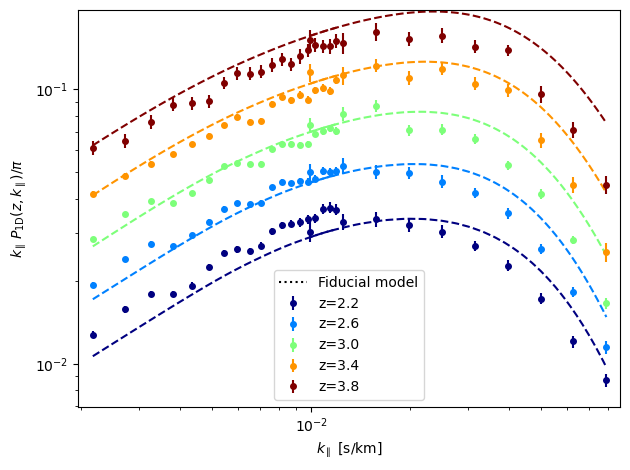

In [18]:
residuals=False
sampling_p1d=100
Nz=len(allz_runs)
# figure out y range for plot
ymin = 1e10
ymax = -1e10
xmin = ymin
xmax = ymax
for iz in range(0,Nz,plot_every_iz):
    col = plt.cm.jet(iz / (Nz - 1))
    yshift = iz / (Nz - 1)
    z=zs[iz]
    sampler=allz_runs[iz]['sampler']
    values=sampler.mle_cube
    values=0.5*np.ones_like(values)
    like=sampler.like
    for highres in [False, True]:
        if highres:
            data = like.extra_p1d_like.data
            label = None
        else:
            data = like.data
            label="z=" + str(np.round(z, 2))
        # get measured bins from data
        k_kms = data.k_kms[0]
        k_emu_kms = np.logspace(np.log10(min(k_kms)), np.log10(max(k_kms)), sampling_p1d)

        # ask emulator prediction for P1D in each bin
        emu_p1d = like.get_p1d_kms([k_emu_kms], values=values, return_covar=False)

        p1d_data = data.get_Pk_iz(0)
        p1d_cov = data.get_cov_iz(0)
        p1d_err = np.sqrt(np.diag(p1d_cov))
        p1d_theory = emu_p1d[0]

        if residuals:
            # interpolate theory to data kp values
            model = np.interp(k_kms, k_emu_kms, p1d_theory)
            plt.errorbar(
                k_kms,
                p1d_data / model + yshift,
                color=col,
                yerr=p1d_err / model,
                fmt="o",
                ms="4",
                label=label,
            )
            ymin = min(ymin, min(p1d_data / model + yshift))
            ymax = max(ymax, max(p1d_data / model + yshift))
            plt.plot(
                k_emu_kms,
                p1d_theory / p1d_theory + yshift,
                color=col,
                linestyle="dashed",
            )
        else:
            plt.errorbar(
                k_kms,
                p1d_data * k_kms / np.pi,
                color=col,
                yerr=p1d_err * k_kms / np.pi,
                fmt="o",
                ms="4",
                label=label,
            )
            plt.plot(
                k_emu_kms,
                (p1d_theory * k_emu_kms) / np.pi,
                color=col,
                linestyle="dashed",
            )
            ymin = min(ymin, min(p1d_data * k_kms / np.pi))
            ymax = max(ymax, max(p1d_data * k_kms / np.pi))
            xmin = min(xmin, min(k_kms))
            xmax = max(xmax, max(k_kms))

if residuals:
    plt.ylabel(r"$P_{\rm 1D}(z,k_\parallel)$ residuals")
    plt.ylim(ymin - 0.1, ymax + 0.1)
else:
    plt.yscale("log")
    plt.ylabel(r"$k_\parallel \, P_{\rm 1D}(z,k_\parallel) / \pi$")
    plt.ylim(0.8 * ymin, 1.2 * ymax)

#plt.plot(-10, -10, linestyle="-", label="Data", color="k")
plt.plot(-10, -10, linestyle=":", label="Fiducial model", color="k")
plt.legend()
plt.xlabel(r"$k_\parallel$ [s/km]")
plt.xlim(0.9*xmin, 1.1*xmax)
plt.xscale('log')
plt.tight_layout()
plt.savefig('p1d_lr_hr_fiducial.png')

### Plot P1D measurements and best-fit theory models (only eBOSS/DESI)

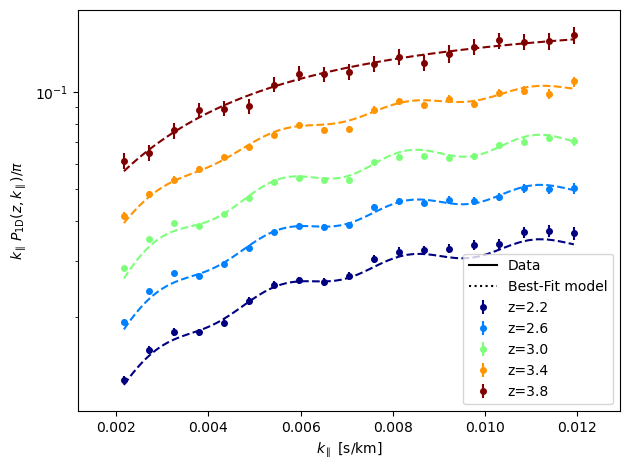

In [19]:
residuals=False
sampling_p1d=100
Nz=len(allz_runs)
# figure out y range for plot
ymin = 1e10
ymax = -1e10
for iz in range(0,Nz,plot_every_iz):
    col = plt.cm.jet(iz / (Nz - 1))
    yshift = iz / (Nz - 1)
    z=zs[iz]
    sampler=allz_runs[iz]['sampler']
    values=sampler.mle_cube
    like=sampler.like
    if True:
        # get measured bins from data
        k_kms = like.data.k_kms[0]
        k_emu_kms = np.logspace(np.log10(min(k_kms)), np.log10(max(k_kms)), sampling_p1d)



        # ask emulator prediction for P1D in each bin
        emu_p1d = like.get_p1d_kms([k_emu_kms], values=values, return_covar=False)

        p1d_data = like.data.get_Pk_iz(0)
        p1d_cov = like.data.get_cov_iz(0)
        p1d_err = np.sqrt(np.diag(p1d_cov))
        p1d_theory = emu_p1d[0]

        if residuals:
            # interpolate theory to data kp values
            model = np.interp(k_kms, k_emu_kms, p1d_theory)
            plt.errorbar(
                k_kms,
                p1d_data / model + yshift,
                color=col,
                yerr=p1d_err / model,
                fmt="o",
                ms="4",
                label="z=" + str(np.round(z, 2)),
            )
            ymin = min(ymin, min(p1d_data / model + yshift))
            ymax = max(ymax, max(p1d_data / model + yshift))
            plt.plot(
                k_emu_kms,
                p1d_theory / p1d_theory + yshift,
                color=col,
                linestyle="dashed",
            )
        else:
            plt.errorbar(
                k_kms,
                p1d_data * k_kms / np.pi,
                color=col,
                yerr=p1d_err * k_kms / np.pi,
                fmt="o",
                ms="4",
                label="z=" + str(np.round(z, 2)),
            )
            plt.plot(
                k_emu_kms,
                (p1d_theory * k_emu_kms) / np.pi,
                color=col,
                linestyle="dashed",
            )
            ymin = min(ymin, min(p1d_data * k_kms / np.pi))
            ymax = max(ymax, max(p1d_data * k_kms / np.pi))

if residuals:
    plt.ylabel(r"$P_{\rm 1D}(z,k_\parallel)$ residuals")
    plt.ylim(ymin - 0.1, ymax + 0.1)
else:
    plt.yscale("log")
    plt.ylabel(r"$k_\parallel \, P_{\rm 1D}(z,k_\parallel) / \pi$")
    plt.ylim(0.8 * ymin, 1.2 * ymax)

plt.plot(-10, -10, linestyle="-", label="Data", color="k")
plt.plot(-10, -10, linestyle=":", label="Best-Fit model", color="k")
plt.legend()
plt.xlabel(r"$k_\parallel$ [s/km]")
plt.xlim(min(k_kms) - 0.001, max(k_kms) + 0.001)
plt.tight_layout()
plt.savefig('p1d_lr_bestfit.png')

### Plot P1D measurements and best-fit theory models (include high-res)

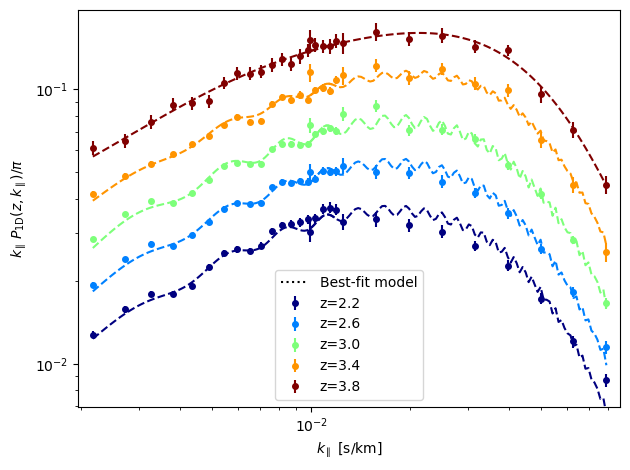

In [20]:
residuals=False
sampling_p1d=100
Nz=len(allz_runs)
# figure out y range for plot
ymin = 1e10
ymax = -1e10
xmin = ymin
xmax = ymax
for iz in range(0,Nz,plot_every_iz):
    col = plt.cm.jet(iz / (Nz - 1))
    yshift = iz / (Nz - 1)
    z=zs[iz]
    sampler=allz_runs[iz]['sampler']
    values=sampler.mle_cube
    #values=0.5*np.ones_like(values)
    like=sampler.like
    for highres in [False, True]:
        if highres:
            data = like.extra_p1d_like.data
            label = None
        else:
            data = like.data
            label="z=" + str(np.round(z, 2))
        # get measured bins from data
        k_kms = data.k_kms[0]
        k_emu_kms = np.logspace(np.log10(min(k_kms)), np.log10(max(k_kms)), sampling_p1d)

        # ask emulator prediction for P1D in each bin
        emu_p1d = like.get_p1d_kms([k_emu_kms], values=values, return_covar=False)

        p1d_data = data.get_Pk_iz(0)
        p1d_cov = data.get_cov_iz(0)
        p1d_err = np.sqrt(np.diag(p1d_cov))
        p1d_theory = emu_p1d[0]

        if residuals:
            # interpolate theory to data kp values
            model = np.interp(k_kms, k_emu_kms, p1d_theory)
            plt.errorbar(
                k_kms,
                p1d_data / model + yshift,
                color=col,
                yerr=p1d_err / model,
                fmt="o",
                ms="4",
                label=label,
            )
            ymin = min(ymin, min(p1d_data / model + yshift))
            ymax = max(ymax, max(p1d_data / model + yshift))
            plt.plot(
                k_emu_kms,
                p1d_theory / p1d_theory + yshift,
                color=col,
                linestyle="dashed",
            )
        else:
            plt.errorbar(
                k_kms,
                p1d_data * k_kms / np.pi,
                color=col,
                yerr=p1d_err * k_kms / np.pi,
                fmt="o",
                ms="4",
                label=label,
            )
            plt.plot(
                k_emu_kms,
                (p1d_theory * k_emu_kms) / np.pi,
                color=col,
                linestyle="dashed",
            )
            ymin = min(ymin, min(p1d_data * k_kms / np.pi))
            ymax = max(ymax, max(p1d_data * k_kms / np.pi))
            xmin = min(xmin, min(k_kms))
            xmax = max(xmax, max(k_kms))

if residuals:
    plt.ylabel(r"$P_{\rm 1D}(z,k_\parallel)$ residuals")
    plt.ylim(ymin - 0.1, ymax + 0.1)
else:
    plt.yscale("log")
    plt.ylabel(r"$k_\parallel \, P_{\rm 1D}(z,k_\parallel) / \pi$")
    plt.ylim(0.8 * ymin, 1.2 * ymax)

#plt.plot(-10, -10, linestyle="-", label="Data", color="k")
plt.plot(-10, -10, linestyle=":", label="Best-fit model", color="k")
plt.legend()
plt.xlabel(r"$k_\parallel$ [s/km]")
plt.xlim(0.9*xmin, 1.1*xmax)
plt.xscale('log')
plt.tight_layout()
plt.savefig('p1d_lr_hr_bestfit.png')